In [0]:
import numpy as np
from skimage import io 
import skimage.transform
import os
from tqdm import tqdm

In [0]:
patch_size = (224, 224)
step_size = 224

ROTATIONS = []
FLIPS = [False, False]

In [0]:
BASE_DIR = 'AerialImageDataset/'
DATASET = 'train'
FOLDER_SUFFIX = '_fold1'
BASE_FOLDER = BASE_DIR + DATASET + '/'
BGR = True
label_values = ['no_building', 'building']

In [4]:
folders = [('gt', BASE_FOLDER + 'gt/', 'austin{}.tif'),
        ('images', BASE_FOLDER + 'images/', 'austin{}.tif')]

import random
nums = [x for x in range(1 ,37)]

random.shuffle(nums)


train_ids = [a for a in nums[:30]]
valid_ids = [b for b in nums[30:]]

print(train_ids)
print(valid_ids)

# Build the target folder name
DATASET_DIR = BASE_FOLDER + DATASET.lower() + '_{}_{}_{}'.format(
                                    patch_size[0], patch_size[1], step_size)
# Add the suffix is not empty
if FOLDER_SUFFIX:
    DATASET_DIR += FOLDER_SUFFIX

DATASET_DIR += '/'

[28, 36, 14, 34, 6, 15, 22, 3, 25, 8, 11, 29, 26, 7, 19, 4, 31, 24, 18, 21, 33, 2, 20, 12, 5, 10, 35, 1, 9, 23]
[30, 13, 32, 17, 27, 16]


In [0]:
palette = {0: (255, 255, 255),  # Building (white)
           1: (0, 0, 0)}        # Background (black)

invert_palette = {(255, 255, 255): 0,  # Building (white)
                  (0, 0, 0): 1}        # Background (black)

NUMBER_OF_CLASSES = len(label_values)

def sliding_window(image, stride=10, window_size=(20,20)):
    patches = []
    # slide a window across the image
    for x in range(0, image.shape[0], stride):
        for y in range(0, image.shape[1], stride):
            new_patch = image[x:x + window_size[0], y:y + window_size[1]]
            if new_patch.shape[:2] == window_size:
                patches.append(new_patch)
    return patches

def transform(patch, flip=False, mirror=False, rotations=[]):
    """Perform data augmentation on a patch.

    Args:
        patch (numpy array): The patch to be processed.
        flip (bool, optional): Up/down symetry.
        mirror (bool, optional): left/right symetry.
        rotations (int list, optional) : rotations to perform (angles in deg).

    Returns:
        array list: list of augmented patches
    """
    transformed_patches = [patch]
    for angle in rotations:
        transformed_patches.append(skimage.img_as_ubyte(skimage.transform.rotate(patch, angle)))
    if flip:
        transformed_patches.append(np.flipud(patch))
    if mirror:
        transformed_patches.append(np.fliplr(patch))
    return transformed_patches

In [0]:
if not os.path.isdir(DATASET_DIR):
    os.mkdir(DATASET_DIR)
else:
    raise Exception("Directory exists, aborted."
                    " Add a specific suffix or remove existing directory with"
                    " same parameters.")
# We write the relevant parameters in a text file
details_file = open(DATASET_DIR + 'details.txt', 'w')
details_file.write('Dataset : ' + DATASET + '\n')
details_file.write('Training tiles : {}\n'.format(train_ids))
details_file.write('Testing tiles : {}\n'.format(valid_ids))
details_file.write('Sliding window patch size : ({},{})\n'.format(*patch_size))
details_file.write('Sliding window stride : {}\n'.format(step_size))
details_file.close()

In [7]:
for suffix, folder, files in tqdm(folders):
    #tqdm.write(("=== PROCESSING {} ===").format(suffix.upper()))
    
    # We create the subfolders splitted in train and test
    os.mkdir(DATASET_DIR + suffix + '_train')
    os.mkdir(DATASET_DIR + suffix + '_valid')
    
    # Generate generators to read the iamges
    train_dataset = (io.imread(folder + files.format(id_)) for id_ in train_ids)
    test_dataset = (io.imread(folder + files.format(id_)) for id_ in valid_ids)
    
    train_samples = []
    test_samples = []
    for image in tqdm(train_dataset):
        # Use the sliding window to extract the patches
        for patches in sliding_window(image, window_size=patch_size, stride=step_size):
            # Append the augmented patches to the sequence
            train_samples.extend(transform(patches, flip=FLIPS[0], mirror=FLIPS[1], rotations=ROTATIONS))

    for image in tqdm(test_dataset):
        # Same as the previous loop, but without data augmentation (test dataset)
        # Sliding window with no overlap
        for patches in sliding_window(image, window_size=patch_size, stride=patch_size[0]):
            test_samples.extend(transform(patches))

    # We save the images on disk
    for i, sample in tqdm(enumerate(train_samples), total=len(train_samples), desc="Saving train samples"):
        io.imsave('{}/{}.png'.format(DATASET_DIR + suffix + '_train', i), sample)

    tqdm.write("({} training set: done)".format(suffix))

    for i, sample in tqdm(enumerate(test_samples), total=len(test_samples), desc="Saving test samples"):
        io.imsave('{}/{}.png'.format(DATASET_DIR + suffix + '_valid', i), sample)
    tqdm.write("({} testing set: done)".format(suffix))
    
    

  0%|          | 0/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  9.71it/s]
3it [00:00, 10.14it/s]
4it [00:00,  9.30it/s]
5it [00:00,  9.48it/s]
7it [00:00,  9.86it/s]
9it [00:00, 10.38it/s]
10it [00:00, 10.17it/s]
12it [00:01, 10.60it/s]
14it [00:01, 10.77it/s]
16it [00:01, 10.92it/s]
18it [00:01, 11.07it/s]
20it [00:01, 11.19it/s]
22it [00:02, 11.45it/s]
24it [00:02, 11.43it/s]
26it [00:02, 11.76it/s]
28it [00:02, 11.78it/s]
30it [00:02, 11.69it/s]

0it [00:00, ?it/s]
2it [00:00, 11.81it/s]
4it [00:00, 11.82it/s]
6it [00:00, 11.92it/s]

Saving train samples:   0%|          | 1/14520 [00:00<27:43,  8.73it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/gt_train/17.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/gt_train/18.png is a low contrast image
  warn(

(gt training set: done)


/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/gt_valid/43.png is a low contrast image
  warn('%s is a low contrast image' % fname)

Saving test samples:   2%|▏         | 44/2904 [00:00<00:12, 223.15it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/gt_valid/45.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/gt_valid/46.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/gt_valid/47.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDatase

(gt testing set: done)



1it [00:00,  2.20it/s]
2it [00:00,  2.28it/s]
3it [00:01,  2.20it/s]
4it [00:01,  2.26it/s]
5it [00:02,  2.13it/s]
6it [00:02,  2.08it/s]
7it [00:03,  2.05it/s]
8it [00:03,  2.05it/s]
9it [00:04,  2.02it/s]
10it [00:04,  2.02it/s]
11it [00:05,  2.03it/s]
12it [00:05,  2.04it/s]
13it [00:06,  2.09it/s]
14it [00:06,  2.09it/s]
15it [00:07,  2.07it/s]
16it [00:07,  2.05it/s]
17it [00:08,  2.04it/s]
18it [00:08,  2.02it/s]
19it [00:09,  2.03it/s]
20it [00:09,  2.02it/s]
21it [00:10,  2.00it/s]
22it [00:10,  2.01it/s]
23it [00:11,  2.01it/s]
24it [00:11,  2.00it/s]
25it [00:12,  2.01it/s]
26it [00:12,  2.00it/s]
27it [00:13,  2.00it/s]
28it [00:13,  1.99it/s]
29it [00:14,  2.01it/s]
30it [00:14,  2.00it/s]

0it [00:00, ?it/s]
1it [00:00,  2.07it/s]
2it [00:00,  2.05it/s]
3it [00:01,  2.03it/s]
4it [00:01,  2.02it/s]
5it [00:02,  2.02it/s]
6it [00:02,  2.04it/s]

Saving train samples:  13%|█▎        | 1938/14520 [00:36<03:45, 55.77it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.p

(images training set: done)



Saving test samples:  76%|███████▌  | 2195/2904 [00:41<00:15, 46.82it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/images_valid/2195.png is a low contrast image
  warn('%s is a low contrast image' % fname)

Saving test samples:  76%|███████▌  | 2212/2904 [00:41<00:14, 47.83it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/images_valid/2215.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/images_valid/2216.png is a low contrast image
  warn('%s is a low contrast image' % fname)

Saving test samples:  77%|███████▋  | 2233/2904 [00:42<00:15, 43.20it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: AerialImageDataset/train/train_224_224_224_fold1/images_valid

(images testing set: done)


In [0]:
import os
import argparse
import shutil
import yaml
import random
import imageio
import time
import collections
import numpy as np


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms.functional as TF

from torch.utils import data
from tqdm import tqdm


from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


In [9]:
print(torch.__version__)
print(torchvision.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1.1.0
0.3.0
cuda


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
        
class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return (
            {
                "Overall Acc: \t": acc,
                "Mean Acc : \t": acc_cls,
                "FreqW Acc : \t": fwavacc,
                "Mean IoU : \t": mean_iu,
            },
            cls_iu,
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))
        
class averageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
        
def CrossEntropyLoss2d(input, target, weight=None):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, reduction='mean', ignore_index=250
    )
    return loss
  
  
def color_to_label(arr_3d):
    
    palette = {1: (255, 255, 255),  # Building (white)
               0: (0, 0, 0)}        # Background (black)
    
    
    invert_palette = {v: k for k, v in palette.items()}
    
    arr_2d = np.zeros((arr_3d.shape[0] , arr_3d.shape[1]) , dtype=np.uint8)
    
    for c,i in invert_palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1,1,3),axis=2)
        arr_2d[m] = i
        
    return arr_2d

def label_to_color(arr_2d):
    palette =  {255:(255, 255, 255),  # Building (white)
                0 :(0,     0, 0)}     # Background (black)
        
    arr_3d = np.zeros((arr_2d.shape[0] , arr_2d.shape[1] , 3) , dtype=np.uint8)
    
    for c,i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i
    return arr_3d
  
def label_to_color_show(arr_2d):
    palette =  {1:(255, 255, 255),  # Building (white)
                0 :(0,     0, 0)}     # Background (black)
        
    arr_3d = np.zeros((arr_2d.shape[0] , arr_2d.shape[1] , 3) , dtype=np.uint8)
    
    for c,i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i
    return arr_3d

In [0]:
class AerialImageLoader(data.Dataset):
    def __init__(
        self, 
        root, 
        split = 'train', 
        is_transform = True,
        img_size = None, 
        augmentations = None,
        img_norm = True,
        test_mode=False):
        
        self.root = root
        self.split = split
        self.img_size = [224,224]
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        
        self.n_classes = 2
        self.files = collections.defaultdict(list)
        
        
        for split in ['train','valid']:
            file_list = os.listdir(root + '/' + 'images_{}'.format(split))
            self.files[split] = file_list
            
    def __len__(self):
        return len(self.files[self.split])
        
        
    def __getitem__(self,index):
        
        image_name = self.files[self.split][index]
        
        image_path = root + '/' + 'images_{}'.format(self.split) + '/' + image_name
                
        image = imageio.imread(image_path)
        image = np.array(image ,dtype=np.uint8)
        
        label_path = image_path.replace('images','gt')
        
        label = label_to_color(imageio.imread(label_path))
        label = color_to_label(label)
        label = np.array(label)
        
        if self.is_transform:
            img , lbl = self.transform(image , label)

        return img , lbl    
        
    def transform(self, img , lbl):
        if self.img_norm:
            img = TF.to_tensor(img)
        lbl = torch.from_numpy(lbl).long()
        return img , lbl

In [12]:
root = BASE_DIR = 'AerialImageDataset/train/train_224_224_224_fold1'

train_dataset = AerialImageLoader(root)

val_dataset = AerialImageLoader(root, 'valid')

print('train_lengh= ',len(train_dataset) , '  val_lengh= ',len(val_dataset))


n_classes = train_dataset.n_classes

batch_size = 16

trainloader = data.DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=0,
                              shuffle=True)
    
valloader = data.DataLoader(val_dataset,
                            batch_size=batch_size,
                            num_workers=0,
                            shuffle=False)

train_lengh=  14520   val_lengh=  2904


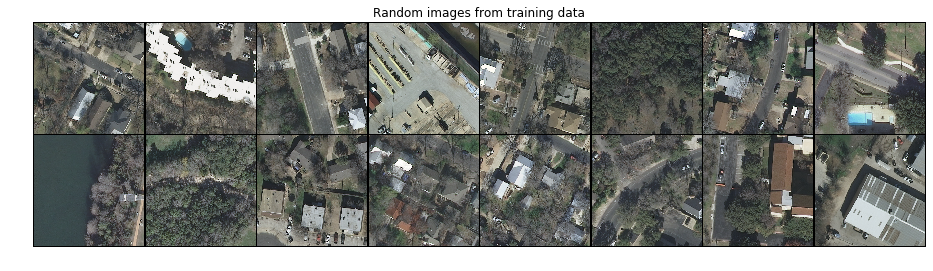

In [0]:
inputs, targets = next(iter(trainloader))
out_image = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out_image ,title= 'Random images from training data')

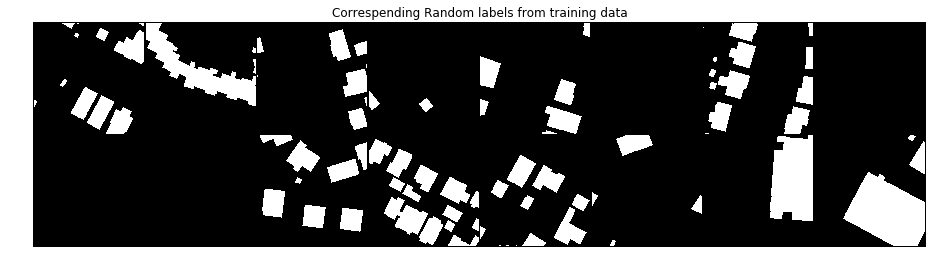

In [0]:
out_labeln = targets.numpy()
out_label = np.zeros((out_labeln.shape[0] , 3 , out_labeln[1,:,:].shape[0] ,out_labeln[1,:,:].shape[1] ) , dtype=np.uint8)
for i in range(out_labeln.shape[0]):
    temp = label_to_color_show(out_labeln[i,:,:])
    temp = temp.transpose(2,0,1)
    out_label[i,:,:,:] = temp
    
out_label = torch.from_numpy(out_label)
out_label = torchvision.utils.make_grid(out_label, padding=3)
plt.figure(figsize=(16, 12))
imshow(out_label ,title= 'Correspending Random labels from training data')

In [0]:
class SegNet(nn.Module):
    """Segnet network."""

    def __init__(self, input_nbr, label_nbr):
        """Init fields."""
        super(SegNet, self).__init__()

        self.input_nbr = input_nbr

        batchNorm_momentum = 0.1

        self.conv11 = nn.Conv2d(input_nbr, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)

        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum=batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum=batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum=batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum=batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum=batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, label_nbr, kernel_size=3, padding=1)

    def forward(self, x):
        """Forward method."""
        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1p, id1 = F.max_pool2d(x12, kernel_size=2, stride=2, return_indices=True)
        size1 = x12.size()

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2p, id2 = F.max_pool2d(x22, kernel_size=2, stride=2, return_indices=True)
        size2 = x22.size()
        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3p, id3 = F.max_pool2d(x33, kernel_size=2, stride=2, return_indices=True)
        size3 = x33.size()

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4p, id4 = F.max_pool2d(x43, kernel_size=2, stride=2, return_indices=True)
        size4 = x43.size()

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5p, id5 = F.max_pool2d(x53, kernel_size=2, stride=2, return_indices=True)
        size5 = x53.size()

        # Stage 5d
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2, output_size=size5)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))

        # Stage 4d
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2, output_size=size4)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2, output_size=size3)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2, output_size=size2)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2, output_size=size1)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)

        return x11d


    def load_from_filename(self, model_path):
        """Load weights method."""
        th = torch.load(model_path)  # load the weigths
        self.load_state_dict(th)

In [0]:
input_nbr = 3
label_nbr = n_classes
model = SegNet(input_nbr,label_nbr)

In [15]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener
    
corresp_name = {
                        "features.0.weight": "conv11.weight",
                        "features.0.bias": "conv11.bias",
                        "features.1.weight": "bn11.weight",
                        "features.1.bias": "bn11.bias",
                        "features.1.running_mean": "bn11.running_mean",
                        "features.1.running_var": "bn11.running_var",

                        "features.3.weight": "conv12.weight",
                        "features.3.bias": "conv12.bias",
                        "features.4.weight": "bn12.weight",
                        "features.4.bias": "bn12.bias",
                        "features.4.running_mean": "bn12.running_mean",
                        "features.4.running_var": "bn12.running_var",

                        "features.7.weight": "conv21.weight",
                        "features.7.bias": "conv21.bias",
                        "features.8.weight": "bn21.weight",
                        "features.8.bias": "bn21.bias",
                        "features.8.running_mean": "bn21.running_mean",
                        "features.8.running_var": "bn21.running_var",

                        "features.10.weight": "conv22.weight",
                        "features.10.bias": "conv22.bias",
                        "features.11.weight": "bn22.weight",
                        "features.11.bias": "bn22.bias",
                        "features.11.running_mean": "bn22.running_mean",
                        "features.11.running_var": "bn22.running_var",

                        # stage 3
                        "features.14.weight": "conv31.weight",
                        "features.14.bias": "conv31.bias",
                        "features.15.weight": "bn31.weight",
                        "features.15.bias": "bn31.bias",
                        "features.15.running_mean": "bn31.running_mean",
                        "features.15.running_var": "bn31.running_var",

                        "features.17.weight": "conv32.weight",
                        "features.17.bias": "conv32.bias",
                        "features.18.weight": "bn32.weight",
                        "features.18.bias": "bn32.bias",
                        "features.18.running_mean": "bn32.running_mean",
                        "features.18.running_var": "bn32.running_var",

                        "features.20.weight": "conv33.weight",
                        "features.20.bias": "conv33.bias",
                        "features.21.weight": "bn33.weight",
                        "features.21.bias": "bn33.bias",
                        "features.21.running_mean": "bn33.running_mean",
                        "features.21.running_var": "bn33.running_var",

                        # stage 4
                        "features.24.weight": "conv41.weight",
                        "features.24.bias": "conv41.bias",
                        "features.25.weight": "bn41.weight",
                        "features.25.bias": "bn41.bias",
                        "features.25.running_mean": "bn41.running_mean",
                        "features.25.running_var": "bn41.running_var",

                        "features.27.weight": "conv42.weight",
                        "features.27.bias": "conv42.bias",
                        "features.28.weight": "bn42.weight",
                        "features.28.bias": "bn42.bias",
                        "features.28.running_mean": "bn42.running_mean",
                        "features.28.running_var": "bn42.running_var",

                        "features.30.weight": "conv43.weight",
                        "features.30.bias": "conv43.bias",
                        "features.31.weight": "bn43.weight",
                        "features.31.bias": "bn43.bias",
                        "features.31.running_mean": "bn43.running_mean",
                        "features.31.running_var": "bn43.running_var",

                        # stage 5
                        "features.34.weight": "conv51.weight",
                        "features.34.bias": "conv51.bias",
                        "features.35.weight": "bn51.weight",
                        "features.35.bias": "bn51.bias",
                        "features.35.running_mean": "bn51.running_mean",
                        "features.35.running_var": "bn51.running_var",

                        "features.37.weight": "conv52.weight",
                        "features.37.bias": "conv52.bias",
                        "features.38.weight": "bn52.weight",
                        "features.38.bias": "bn52.bias",
                        "features.38.running_mean": "bn52.running_mean",
                        "features.38.running_var": "bn52.running_var",

                        "features.40.weight": "conv53.weight",
                        "features.40.bias": "conv53.bias",
                        "features.41.weight": "bn53.weight",
                        "features.41.bias": "bn53.bias",
                        "features.41.running_mean": "bn53.running_mean",
                        "features.41.running_var": "bn53.running_var",
                        }    
    
# Download VGG-16 weights from PyTorch

vgg_url='https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url,'./vgg16_bn-6c64b313.pth')

pretrained_sd = torch.load('./vgg16_bn-6c64b313.pth')

s_dict = model.state_dict()

for name in pretrained_sd:
    if name not in corresp_name:
        continue
    if("features.0" not in name) or (input_nbr==3):
        s_dict[corresp_name[name]] = pretrained_sd[name]
model.load_state_dict(s_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
model = model.to(device)

train_args = {
    'epoch_num': 25,
    'lr': 1e-2,
    'weight_decay': 1e-4,
    'momentum': 0.95,
    'lr_patience': 6,  # large patience denotes fixed lr
    'snapshot': '',  # empty string denotes learning from scratch
    'print_freq': 100,
    'val_save_to_img_file': False,
    'val_img_sample_rate': 0.1  # randomly sample some validation results to display
}
model.train()

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

params_dict = dict(model.named_parameters())
params = []

for key, value in params_dict.items():
    if 'd' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': train_args['lr']}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': train_args['lr'] / 2}]

if len(train_args['snapshot']) == 0:
    curr_epoch = 1
    train_args['best_record'] = {'epoch': 0, 'val_loss': 1e10, 'acc': 0, 'acc_cls': 0, 'mean_iu': 0, 'fwavacc': 0}

optimizer = optim.SGD(model.parameters(), lr=train_args['lr'], momentum=train_args['momentum'])
                       
criterion = CrossEntropyLoss2d

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=train_args['lr_patience'], min_lr=1e-10, verbose=True)

In [0]:
def train(train_loader, net, criterion, optimizer, epoch, train_args):
    train_loss = averageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        assert inputs.size()[2:] == labels.size()[1:]
        N = inputs.size(0)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        assert outputs.size()[2:] == labels.size()[1:]
        assert outputs.size()[1] == n_classes

        loss = criterion(outputs, labels) / N
        loss.backward()
        optimizer.step()

        train_loss.update(loss.item(), N)

        curr_iter += 1
        writer.add_scalar('train_loss', train_loss.avg, curr_iter)

        if (i + 1) % train_args['print_freq'] == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg
            ))

def _fast_hist(label_pred, label_true, num_classes):
    mask = (label_true >= 0) & (label_true < num_classes)
    hist = np.bincount(
        num_classes * label_true[mask].astype(int) +
        label_pred[mask], minlength=num_classes ** 2).reshape(num_classes, num_classes)
    return hist
  
def evaluate(predictions, gts, num_classes):
    hist = np.zeros((num_classes, num_classes))
    for lp, lt in zip(predictions, gts):
        hist += _fast_hist(lp.flatten(), lt.flatten(), num_classes)
    # axis 0: gt, axis 1: prediction
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc
  
def validate(val_loader, net, criterion, optimizer, epoch, train_args ):
    net.eval()
  
    val_loss_meter = averageMeter()
    inputs_all, gts_all, predictions_all = [], [], []
  
    with torch.no_grad():
        for i_val , data in enumerate(val_loader):
          inputs, labels = data
          N = inputs.size(0)
      
          inputs = inputs.to(device)
          labels = labels.to(device)
      
          outputs = net(inputs)
          val_loss = criterion(input=outputs, target=labels)
      
          predictions = outputs.data.max(1)[1].cpu().numpy() 
      
          val_loss_meter.update(val_loss.item()/N , N)
      
          if random.random() > train_args['val_img_sample_rate']:
              inputs_all.append(None)
          else:
              inputs_all.append(inputs.data.cpu())
        
          gts_all.append(labels.data.cpu().numpy())
          predictions_all.append(predictions)

      
    acc, acc_cls, mean_iu, fwavacc = evaluate(predictions_all, gts_all, n_classes)
      
    
    if mean_iu > train_args['best_record']['mean_iu']:
        train_args['best_record']['val_loss'] = val_loss_meter.avg
        train_args['best_record']['epoch'] = epoch
        train_args['best_record']['acc'] = acc
        train_args['best_record']['acc_cls'] = acc_cls
        train_args['best_record']['mean_iu'] = mean_iu
        train_args['best_record']['fwavacc'] = fwavacc
        
        torch.save(net.state_dict(), 'model_SegNet.pth')
        torch.save(optimizer.state_dict(), 'optimizer_SegNet_param.pth')
        
    
    
    print('--------------------------------------------------------------------')
    
    print('[epoch %d], [val loss %.5f], [acc %.5f], [acc_cls %.5f], [mean_iu %.5f], [fwavacc %.5f]' % (
        epoch, val_loss_meter.avg, acc, acc_cls, mean_iu, fwavacc))
    
    print('best record: [val loss %.5f], [acc %.5f], [acc_cls %.5f], [mean_iu %.5f], [fwavacc %.5f], [epoch %d]' % (
        train_args['best_record']['val_loss'], train_args['best_record']['acc'], train_args['best_record']['acc_cls'],
        train_args['best_record']['mean_iu'], train_args['best_record']['fwavacc'], train_args['best_record']['epoch']))
      
    print('--------------------------------------------------------------------')
    
    writer.add_scalar('val_loss', val_loss_meter.avg, epoch)
    writer.add_scalar('acc', acc, epoch)
    writer.add_scalar('acc_cls', acc_cls, epoch)
    writer.add_scalar('mean_iu', mean_iu, epoch)
    writer.add_scalar('fwavacc', fwavacc, epoch)
    #writer.add_scalar('lr', optimizer.param_groups[1]['lr'], epoch)
    
    net.train()
    
    return val_loss_meter.avg

In [19]:
writer = SummaryWriter()

for epoch in range(curr_epoch, train_args['epoch_num'] + 1):
    train(trainloader, model, criterion, optimizer, epoch, train_args)
    val_loss = validate(valloader, model, criterion, optimizer, epoch, train_args)
    scheduler.step(val_loss)

[epoch 1], [iter 100 / 908], [train loss 0.02889]
[epoch 1], [iter 200 / 908], [train loss 0.02751]
[epoch 1], [iter 300 / 908], [train loss 0.02707]
[epoch 1], [iter 400 / 908], [train loss 0.02661]
[epoch 1], [iter 500 / 908], [train loss 0.02559]
[epoch 1], [iter 600 / 908], [train loss 0.02436]
[epoch 1], [iter 700 / 908], [train loss 0.02327]
[epoch 1], [iter 800 / 908], [train loss 0.02233]
[epoch 1], [iter 900 / 908], [train loss 0.02154]
--------------------------------------------------------------------
[epoch 1], [val loss 0.01484], [acc 0.90587], [acc_cls 0.75228], [mean_iu 0.68036], [fwavacc 0.83112]
best record: [val loss 0.01484], [acc 0.90587], [acc_cls 0.75228], [mean_iu 0.68036], [fwavacc 0.83112], [epoch 1]
--------------------------------------------------------------------
[epoch 2], [iter 100 / 908], [train loss 0.01355]
[epoch 2], [iter 200 / 908], [train loss 0.01343]
[epoch 2], [iter 300 / 908], [train loss 0.01337]
[epoch 2], [iter 400 / 908], [train loss 0.01